Demontis, Ambra, et al. "Why do adversarial attacks transfer? Explaining transferability of evasion and poisoning attacks." 28th USENIX security symposium (USENIX security 19). 2019.

To reproduce the results, use this code from SecML library. Instead of the toy example with CDLRandomBlobs, you can load MNIST dataset from MNIST data loader and you can get DREBIN dataset here. 


Paper:https://www.usenix.org/system/files/sec19-demontis.pdf


Useful links from the projectfile:

https://secml.readthedocs.io/en/v0.15/tutorials/13-Android-Malware-Detection.html

https://secml.readthedocs.io/en/v0.15/secml.data.loader.html#module-secml.data.loader.c_dataloader_mnist

https://figshare.com/articles/dataset/Android_malware_dataset_for_machine_learning_2/5854653

20-25 min for the presentation + 5-10 for questions

Don't show code on the slides

Present content of the paper + show what we have done with some graphs or tables

Be curious - look for why results are different or play with some variables

**Remember to run it in the conda - I have python 3.10 and I need 3.8 for secml**

https://secml.readthedocs.io/en/v0.15/tutorials/04-Transferability.html

This link seems more useful than the one with malware detection.

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
    import secml
except ImportError:
    %pip install git+https://gitlab.com/secml/secml
    import secml

In [2]:
# NBVAL_IGNORE_OUTPUT
import re
import secml
from secml import settings
from secml.utils import fm
from secml.utils.download_utils import dl_file_gitlab

repo_url = 'https://gitlab.com/secml/secml-zoo'
file_name = 'drebin-reduced.tar.gz'
file_path = 'datasets/DrebinRed/' + file_name
output_dir = fm.join(settings.SECML_DS_DIR, 'drebin-red')
md5_digest = 'ecf87ddedf614dd53b89285c29cf1caf'

ds_path = fm.join(output_dir, file_name)

# The following tries to get the correct dataset for the current library version
if not fm.file_exist(ds_path):
    try:
        # Try downloading from the branch corresponding to current version
        min_version = re.search(r'^\d+.\d+', secml.__version__).group(0)
        dl_file_gitlab(repo_url, file_path, output_dir,
                       branch='v' + min_version, md5_digest=md5_digest)

    except Exception as e:  # Try looking into 'master' branch...
        dl_file_gitlab(repo_url, file_path, output_dir, md5_digest=md5_digest)

In [3]:
from secml.utils import pickle_utils

ds = pickle_utils.load(ds_path)

print("Num. samples: ", ds.num_samples)

n_neg = sum(ds.Y == 0)
n_pos = sum(ds.Y == 1)

print("Num. benign samples: ", n_neg)
print("Num. malicious samples: ", n_pos)

print("Num. features: ", ds.num_features)

Num. samples:  12550
Num. benign samples:  12000
Num. malicious samples:  550
Num. features:  1227080


In [4]:
from secml.data.splitter import CTrainTestSplit

tr, ts = CTrainTestSplit(6000, random_state=0).split(ds)

from secml.ml.classifiers import CClassifierSVM

clf = CClassifierSVM(C=0.1)

print("Training started...")
clf.fit(tr.X, tr.Y)
print("Training completed!")

Training started...
Training completed!


In [5]:
# Classification of test set and computation of performance metrics
y_pred, score_pred = clf.predict(ts.X, return_decision_function=True)

from secml.ml.peval.metrics import CMetricTPRatFPR, CMetricF1, CRoc

fpr_th = 0.02  # 2% False Positive Rate

dr = CMetricTPRatFPR(fpr=fpr_th).performance_score(y_true=ts.Y, score=score_pred[:, 1].ravel())
print("Detection rate @ 2% FPR: {:.2%}".format(dr))

f1 = CMetricF1().performance_score(y_true=ts.Y, y_pred=y_pred)
print("F1 score: {:.2%}".format(f1))

Detection rate @ 2% FPR: 95.04%
F1 score: 89.09%


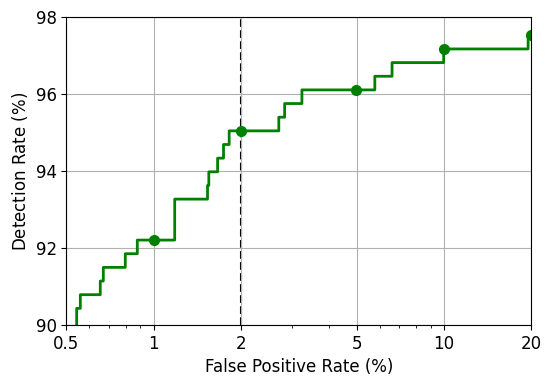

In [6]:
fpr, tpr, _ = CRoc().compute(y_true=ts.Y, score=score_pred[:, 1].ravel())

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=4, width=6)
fig.sp.plot_roc(fpr, tpr)
fig.sp._sp.axvline(x=2,  c='k', linestyle='--', zorder=-1)
fig.sp.xlim(0.5, 20)
fig.sp.ylim(90, 98)
fig.sp.yticks([90, 92, 94, 96, 98])
fig.sp.yticklabels([90, 92, 94, 96, 98])
fig.sp.ylabel(r'Detection Rate $(\%)$')

In [7]:
from secml.explanation import CExplainerGradientInput

expl = CExplainerGradientInput(clf)

print("Computing explanations using '{:}'".format(expl.__class__.__name__))

Computing explanations using 'CExplainerGradientInput'


In [8]:
# Explanations for a benign sample
i = 137
x, y = ts[i, :].X, ts[i, :].Y

print("Explanations for sample {:} (true class: {:})".format(i, y.item()))

attr = expl.explain(x, y=1)
attr = attr / attr.norm(order=1)  # To display values in 0-100

attr_argsort = abs(attr).argsort().ravel()[::-1]

n_plot = 10

for i in attr_argsort[:10]:
    print("{:6.2f}\t{:}".format(attr[i].item() * 100, ds.header.feat_desc[i]))

Explanations for sample 137 (true class: 0)
 -8.30	req_permissions::android.permission.CALL_PHONE
 -6.59	suspicious_calls::android/net/Uri;->toString
  5.60	req_permissions::android.permission.INTERNET
 -5.39	used_permissions::ACCESS_NETWORK_STATE
 -5.08	api_calls::android/media/MediaPlayer;->start
 -4.24	used_permissions::VIBRATE
 -3.65	intent_filters::android.intent.category.LAUNCHER
 -3.56	req_permissions::android.permission.ACCESS_FINE_LOCATION
 -3.43	used_permissions::ACCESS_FINE_LOCATION
 -2.63	api_calls::android/location/LocationManager;->getLastKnownLocation


In [9]:
# Explanations for a malware
i = 138
x, y = ts[i, :].X, ts[i, :].Y

print("Explanations for sample {:} (true class: {:})".format(i, y.item()))

attr = expl.explain(x, y=1)
attr = attr / attr.norm(order=1)  # To display values in 0-100

attr_argsort = abs(attr).argsort().ravel()[::-1]

n_plot = 10

for i in attr_argsort[:10]:
    print("{:6.2f}\t{:}".format(attr[i].item() * 100, ds.header.feat_desc[i]))

Explanations for sample 138 (true class: 1)
 15.18	suspicious_calls::android/telephony/TelephonyManager;->getNetworkOperator
 12.55	req_permissions::android.permission.SEND_SMS
  8.69	req_permissions::android.permission.READ_SMS
  5.83	req_permissions::android.permission.INTERNET
  5.58	intent_filters::android.intent.action.BOOT_COMPLETED
 -4.41	used_permissions::VIBRATE
  3.96	intent_filters::android.intent.category.HOME
 -3.80	intent_filters::android.intent.category.LAUNCHER
  3.66	receivers::com.google.android.c2dm.C2DMBroadcastReceiver
  3.39	req_permissions::android.permission.READ_PHONE_STATE


In [10]:
# Attack parameters
params = {
    "classifier": clf,
    "distance": 'l1',
    "double_init": False,
    "lb": 'x0',
    "ub": 1,
    "attack_classes": 'all',
    "y_target": 0,
    "solver_params": {'eta': 1, 'eta_min': 1, 'eta_max': None, 'eps': 1e-4}
}

from secml.adv.attacks.evasion import CAttackEvasionPGDLS

evasion = CAttackEvasionPGDLS(**params)

In [11]:
n_mal = 10

# Attack DS
mal_idx = ts.Y.find(ts.Y == 1)[:n_mal]
adv_ds = ts[mal_idx, :]

# Security evaluation parameters
param_name = 'dmax'  # This is the `eps` parameter
dmax_start = 0
dmax = 28
dmax_step = 4

from secml.array import CArray

param_values = CArray.arange(
    start=dmax_start, step=dmax_step, stop=dmax + dmax_step)

from secml.adv.seceval import CSecEval

sec_eval = CSecEval(
    attack=evasion,
    param_name=param_name,
    param_values=param_values)

print("Running security evaluation...")
sec_eval.run_sec_eval(adv_ds)
print("Security evaluation completed!")

Running security evaluation...
Security evaluation completed!


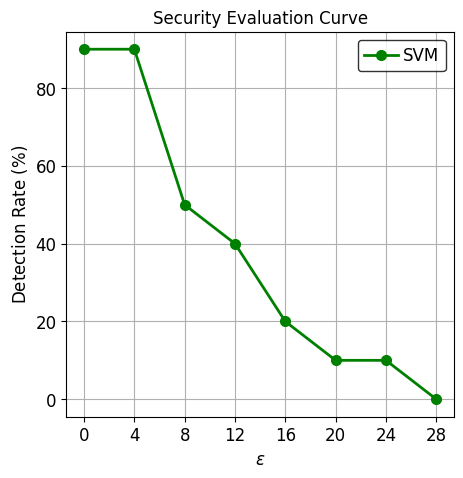

In [12]:
from secml.figure import CFigure
fig = CFigure(height=5, width=5)

from secml.ml.peval.metrics import CMetricTHatFPR, CMetricTPRatTH

# Get the ROC threshold at which Detection Rate should be computed
th = CMetricTHatFPR(fpr=fpr_th).performance_score(y_true=ts.Y, score=score_pred[:, 1].ravel())

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(sec_eval.sec_eval_data, metric=CMetricTPRatTH(th=th),
                     percentage=True, label='SVM', color='green', marker='o')
fig.sp.ylabel(r'Detection Rate $(\%)$')
fig.sp.xlabel(r"$\varepsilon$")

Is this code above relevant ??
The main code is below

In [26]:
#Load the dataset
random_state = 999
'''

n_features = 2  # Number of features
n_samples = 2250  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.8  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()
'''

from secml.data.loader import CDataLoaderMNIST
mnist_loader = CDataLoaderMNIST()
tr = mnist_loader.load(ds='training', digits=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
ts = mnist_loader.load(ds='testing', digits=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

#This dataset is not normalized, so it has to be normalized similarly to blobs

''' Blob code
n_tr = 1000  # Number of training set samples
n_ts = 250  # Number of test set samples

# Split in training and test.
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=2 * n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)
'''

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)


''' Blob code
# Generate 2 training datasets for surrogate and target classifiers
tr1 = tr[:n_tr, :]  # Source classifier training set
tr2 = tr[n_tr:, :]  # Target classifier training set
'''

# Get the size of the training dataset
num_samples, num_features = tr.X.shape
tr1 = tr[:int(num_samples/2), :]  # Source classifier training set
tr2 = tr[int(num_samples/2):, :]  # Target classifier training set

In [9]:
from collections import namedtuple
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')

from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
# Binary classifiers
from secml.ml.classifiers import CClassifierSVM, CClassifierSGD
# Natively-multiclass classifiers
from secml.ml.classifiers import CClassifierKNN, CClassifierDecisionTree, CClassifierRandomForest

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

surr_clf = CLF(
    clf_name='SVM Linear H',
    clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
    xval_parameters={'C': [100]})

''' I have just one set of values - the one from the paper
print("Estimating the best training parameters of the surrogate classifier...")
best_params = surr_clf.clf.estimate_parameters(
    dataset=tr1,
    parameters=surr_clf.xval_parameters,
    splitter=xval_splitter,
    metric=metric,
    perf_evaluator='xval'
)
print("The best training parameters of the surrogate classifier are: ",
      [(k, best_params[k]) for k in sorted(best_params)])
'''

print("\nTraining the surrogate classifiers...")

surr_clf.clf.fit(tr1.X, tr1.Y)

y_pred = surr_clf.clf.predict(ts.X)

acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy of the surrogate classifier on test set: {:.2%}".format(acc))


''' 
    #Something is wrong with this one
    CLF(clf_name='Logistic (SGD)',
        clf=CClassifierMulticlassOVA(
            CClassifierSGD, regularizer='l2', loss='loss',
            random_state=random_state),
        xval_parameters={'alpha': [1e-6, 1e-5, 1e-4]}),
     
    #Not used in a paper
    CLF(clf_name='kNN',
        clf=CClassifierKNN(),
        xval_parameters={'n_neighbors': [30, 40, 50]}),
'''

print("\nTraining the target classifiers...")


Training the surrogate classifiers...
Accuracy of the surrogate classifier on test set: 93.00%

Training the target classifiers...


In [5]:
target_clf_list = [
    CLF(
        clf_name='SVM Linear H',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [100]}),
    CLF(
        clf_name='SVM Linear L',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [0.1]}),
]

'''Run one by one or my computer will die 
    CLF(clf_name='SVM RBF H',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [100],  'kernel.gamma': [0.01]}),
    CLF(clf_name='SVM RBF L',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [1],  'kernel.gamma': [0.01]}),
    CLF(clf_name='Decision Tree H',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [16]}),
    CLF(clf_name='Decision Tree L',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [8]}),
    CLF(clf_name='Random Forest H',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [30], 'max_depth': [16]}),
    CLF(clf_name='Random Forest L',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [30], 'max_depth': [8]}),
'''

print("\nClassifiers trained...")


Classifiers trained...


In [6]:
for i, test_case in enumerate(target_clf_list):
    clf = test_case.clf
    xval_params = test_case.xval_parameters

    '''No best parameters for now, I use data from the papers
    print("\nEstimating the best training parameters of {:} ..."
          "".format(test_case.clf_name))
    
    best_params = clf.estimate_parameters(
        dataset=tr2, parameters=xval_params, splitter=xval_splitter,
        metric='accuracy', perf_evaluator='xval')
            
    print("The best parameters for '{:}' are: ".format(test_case.clf_name),
          [(k, best_params[k]) for k in sorted(best_params)])

    '''
    print("Training of {:} ...".format(test_case.clf_name))
    clf.fit(tr2.X, tr2.Y)

    # Predictions on test set and performance evaluation
    y_pred = clf.predict(ts.X)
    acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

    print("Classifier: {:}\tAccuracy: {:.2%}".format(test_case.clf_name, acc))

Training of SVM Linear H ...
Classifier: SVM Linear H	Accuracy: 91.70%
Training of SVM Linear L ...
Classifier: SVM Linear L	Accuracy: 91.70%


Change "loss = log" to "loss = log_loss" in the:

 CLF(clf_name='Logistic (SGD)',
        clf=CClassifierMulticlassOVA(
            CClassifierSGD, regularizer='l2', loss='log_loss',
            random_state=random_state),
        xval_parameters={'alpha': [1e-6, 1e-5, 1e-4]}),
        
This change causes:  no class of type `log_loss` is a subclass of 'CLoss' from module 'secml.ml.classifiers.loss.c_loss'

In [25]:
#It would take me around 170 hours to run evasion attack on the default configuration. 

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 0.4  # Maximum perturbation
lb, ub = 0, 1  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 2  # `error-specific` attack. None for `error-generic`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 1e-1,
    'eta_min': 0.1,
    'eta_max': None,
    'max_iter': 25,
    'eps': 1e-1
}

from secml.adv.attacks.evasion import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=surr_clf.clf,
    double_init_ds=tr1,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

#Again it is very computationally intensive, run a test on a small subset (1%) and check time
smallerts = ts[100:300, :]

# Run the evasion attack on x0
print("Attack started...")
y_pred, scores, adv_ds, f_obj = pgd_ls_attack.run(smallerts.X, smallerts.Y)
print("Attack complete!")

IndexError: stop element of index 0, slice(None, None, 200), is out of bounds.


Testing transferability of SVM Linear H
Test error (no attack): 4.00%

Testing transferability of SVM Linear L
Test error (no attack): 4.00%


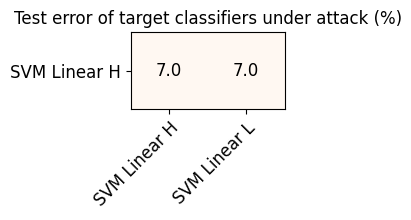


Average transfer rate: 7.00%


In [21]:
# Metric to use for testing transferability
from secml.ml.peval.metrics import CMetricTestError
metric = CMetricTestError()

trans_error = []
transfer_rate = 0.0
for target_clf in target_clf_list:

    print("\nTesting transferability of {:}".format(target_clf.clf_name))

    origin_error = metric.performance_score(
            y_true=smallerts.Y, y_pred=target_clf.clf.predict(smallerts.X))

    print("Test error (no attack): {:.2%}".format(origin_error))

    trans_error_clf = metric.performance_score(
        y_true=smallerts.Y, y_pred=target_clf.clf.predict(adv_ds.X))

    trans_error.append(trans_error_clf)
    transfer_rate += trans_error_clf

# Computing the transfer rate
transfer_rate /= len(target_clf_list)

from secml.array import CArray
trans_acc = CArray(trans_error) * 100  # Show results in percentage

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=1)
a = fig.sp.imshow(trans_acc.reshape((1, len(target_clf_list))),
                  cmap='Oranges', interpolation='nearest',
                  alpha=.65, vmin=60, vmax=70)

fig.sp.xticks(CArray.arange((len(target_clf_list))))
fig.sp.xticklabels([c.clf_name for c in target_clf_list],
                   rotation=45, ha="right", rotation_mode="anchor")
fig.sp.yticks([0])
fig.sp.yticklabels([surr_clf.clf_name])

for i in range(len(target_clf_list)):
    fig.sp.text(i, 0, trans_acc[i].round(2).item(), va='center', ha='center')

fig.sp.title("Test error of target classifiers under attack (%)")

fig.show()

print("\nAverage transfer rate: {:.2%}".format(transfer_rate))

Here I changed hardcoded 6 elements into len(target_clf_list), because at the moment one of the classifiers does not work.

ValueError: shapes (2500,2) and (784,711) not aligned: 2 (dim 1) != 784 (dim 0)

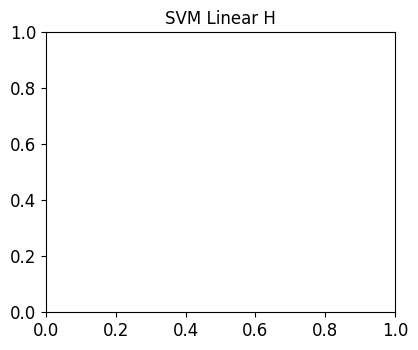

In [13]:
from secml.figure import CFigure
from secml.array import CArray
from math import ceil
fig = CFigure(width=4.5 * len(target_clf_list) / 2,
              height=4 * 2, markersize=10)

for clf_idx in range(len(target_clf_list)):
    clf = target_clf_list[clf_idx].clf

    fig.subplot(2, int(ceil(len(target_clf_list) / 2)), clf_idx + 1)
    fig.sp.title(target_clf_list[clf_idx].clf_name)

    fig.sp.plot_decision_regions(clf, n_grid_points=50)
    fig.sp.grid(grid_on=False)

    s_idx = ts.Y.find(ts.Y != y_target)

    for pt in s_idx[:10]:  # Plot the translation of multiple adversarial samples
        pt_segment = CArray.append(ts.X[pt, :], adv_ds.X[pt, :], axis=0)
        fig.sp.plot_path(pt_segment)

    acc = metric.performance_score(
        y_true=ts[s_idx[:10], :].Y, y_pred=clf.predict(adv_ds[s_idx[:10], :].X))

    fig.sp.text(0.01, 0.01, "Transfer attack success: {:.1%}".format(acc),
                bbox=dict(facecolor='white'))

fig.show()
